# Import Package and Data

In [1]:
!pip install -q kaggle

In [2]:
# I upload the GloVe to my google drive to save uoloading time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
# fucntions related package
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
from shutil import copyfile
from google.colab import files
import re
from collections import Counter

# data visulization related package
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# deep learning related package
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN



# evaluation related package
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# load the dataset
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 917MB/s]


In [6]:
# open the .zip file  by read it and push them into the data folder
with ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
    zip_ref.extract("train.csv")
    zip_ref.extract("test.csv", path="data")


In [7]:
glove_path = '/content/drive/MyDrive/CU Boulder MSCS/introduction to deep learning/week4/glove.6B.100d.txt'

#Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data

## challenge problem

This NLP problem is focus on classifying whether a twiter text is related to diasater or not .So given a text from twitter, determine if it is disaster related.

##Describe the size, dimension, structure, etc., of the data

In [8]:
df = pd.read_csv("train.csv")
# for submission only
test_df = pd.read_csv("data/test.csv")

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


Tjere are 7613 rows of data, there are lots of missing value in the location and the keyword columns, but since i only interested in the text column, and there is no missing value, I do not need to do any impute.

In [10]:
print(df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


The train.csv data have 5 columns , id , keyword, location,text,target

In the target column, 1 indicate disaster related, 0 indicate not disaster related.

For the purpose of this project, i will only use the data from text column

## NLP


NLP is dthe process of  converting the natural human language into numerical indicators, so that they can be fed into machine.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

## Visualizations

### Histograms of Text Length

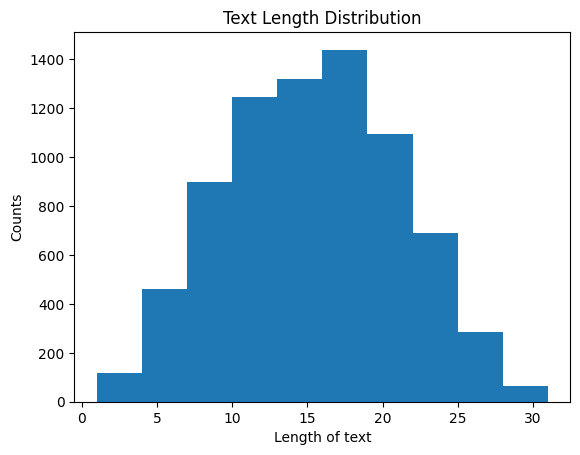

In [11]:
# get the length of the text
text_length = df['text'].str.split().apply(len)

# make the histgrams plot
plt.hist(text_length)
# add title
plt.title("Text Length Distribution")

# add label for both x and y
plt.xlabel("Length of text")
plt.ylabel("Counts")
plt.show()

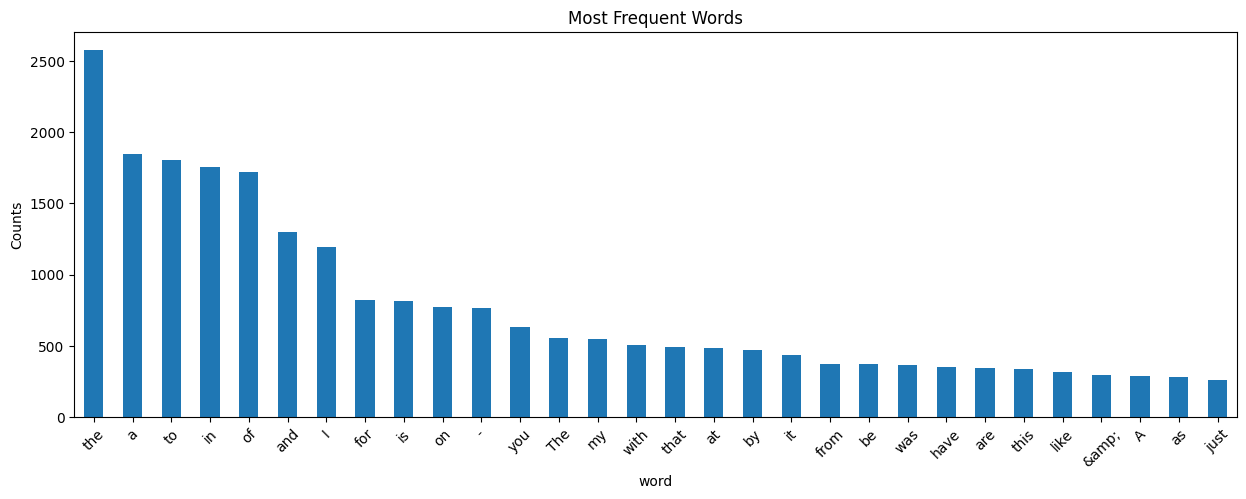

In [12]:
# get all the words from the text columns
all_words = " ".join(df['text'].astype(str)).split()

# get the top 30 words
top_30_words = Counter(all_words).most_common(30)

top_words = pd.DataFrame(top_30_words, columns=['word', 'count'])

top_words.plot.bar(x='word', y='count', legend=False, figsize=(15, 5))
plt.title("Most Frequent Words")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

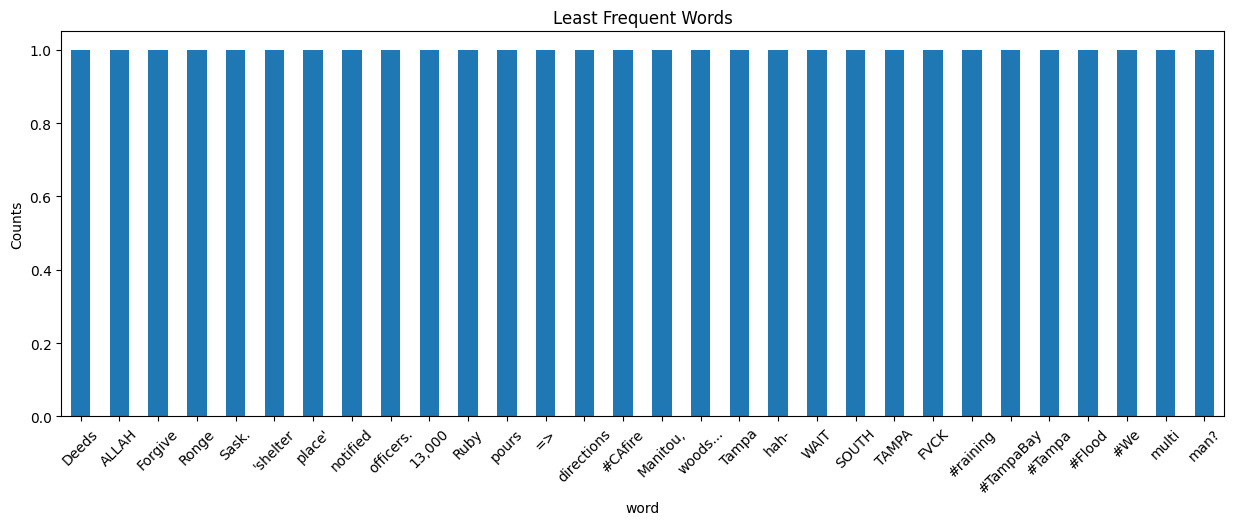

In [13]:
# get the least comment words
least_30_words = sorted(Counter(all_words).items(), key=lambda x: x[1])[:30]


bottom_words = pd.DataFrame(least_30_words, columns=['word', 'count'])

bottom_words.plot.bar(x='word', y='count', legend=False, figsize=(15, 5))
plt.title("Least Frequent Words")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

In [76]:
print(df['target'].value_counts())

target
0    2884
1    2196
Name: count, dtype: int64


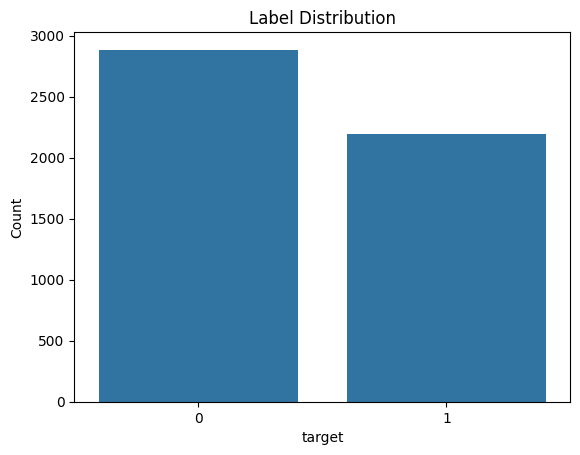

In [77]:
sns.countplot(x='target', data=df)
plt.title("Label Distribution")
plt.ylabel("Count")
plt.show()

### Data Cleaning

In [14]:
# read the data
df = pd.read_csv("train.csv")

In [15]:
# check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [16]:
# remove the empty space(start and end )
df = df[df['text'].str.strip() != '']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [18]:
# drop the empty

df = df[df['text'].str.strip() != '']


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [20]:
df = df.dropna(subset=['location', 'keyword'])

In [21]:
print(df.head())

    id keyword                       location  \
31  48  ablaze                     Birmingham   
32  49  ablaze  Est. September 2012 - Bristol   
33  50  ablaze                         AFRICA   
34  52  ablaze               Philadelphia, PA   
35  53  ablaze                     London, UK   

                                                 text  target  
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32  We always try to bring the heavy. #metal #RT h...       0  
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
34                 Crying out for more! Set me ablaze       0  
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


In [23]:
# get the text and the values
texts = df['text'].values

labels = df['target'].values

In [24]:
# quick check

print(texts.shape)
print(labels.shape)


(5080,)
(5080,)


### plan of analysis

I will use GloVe to do the NLP part, and then i will fed the data into GRU and RNN models, and evaluate the result based on accuracy and F1 Score

#Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

##  DL model architecture  and Reasoning

I decide to run the GRU and RNN models in bidirectional , not the LSTM model for mainly 2 reasons.

1.The maximum length of the text is like 30 words, and this is way too short for the LSTM model, using LSTM model is very likely cause overfitting.

2.Efficiency, the LSTM model will run slower than the GRU and RNN models.


## Word embeddings

### My understood of Word embeddings
including explanations in my own words

**So basically, in oder to fed the Natural language data in DL models, the natural language must be converted to numeric data.**

**word embeddings is the process to conver text into dense vectors that can captur the meaning of word.**

**For example, if the dimentaion being set to 100, it means using a vector with 100 values to indicate a words **

**like Disaster might be [0.18,0.12.....98 more values here..]**


### Briefly explain the method(s) and how they work in your own words.

I decide to chose the GloVe as the method to process texts to matrix(word embedding) for mainly 2 reasons

1. it is pre-trained, so i do not need to create my own matrix, i can just download and use it.

2. the maximum length  is like 30 , so GloVe is better, Word2Vec is too big and complicated for this project.


GloVe is based on the idea that words exsist in the similar text, then they should have similar  meanings.

I am using the glove.6B.100d.txt for this project,  each word in this file is represented by  a dense vector with 100 valus.


### Build and train your sequential neural network model

In [25]:
# init an empty dict  # word -> vector_from_glove
embedding_index = {}

with open(glove_path) as txt_file:
    for line in txt_file:
        values = line.split()
        word = values[0]
        # 64 will be hard to train
        vector = np.asarray(values[1:], dtype='float32')

        embedding_index[word] = vector


In [26]:
# quick check the length
print(len(embedding_index))

400000


In [27]:
# quick check if the dict is working
print(embedding_index['from'])

[ 3.0731e-01  2.4737e-01  6.8231e-01 -5.2367e-01  4.4053e-01  4.2044e-01
  2.5140e-04  1.5265e-01 -6.1363e-01  2.2631e-01  8.3071e-02  7.0425e-02
  1.7683e-02  5.6807e-01  1.0067e+00 -4.6206e-01  4.4524e-01 -5.0984e-01
 -4.2985e-01  1.9935e-01  2.2729e-01  5.1662e-01  5.6282e-01  4.1282e-01
  1.7742e-01 -1.5694e-01 -1.1505e-01 -3.8050e-01  4.7440e-01 -1.6686e-01
  2.3153e-01  6.3698e-02 -1.0716e-01 -2.6848e-01 -4.2665e-01  5.2237e-01
  9.5376e-02  6.4020e-01 -5.2221e-01 -1.3856e-01 -9.8307e-01 -3.5320e-01
 -5.2161e-01  1.1277e-01  3.1634e-01  1.3297e-01 -4.9571e-02 -1.3785e-01
  1.1317e-01 -5.0644e-01  3.8373e-01  3.6698e-01  3.9106e-01  9.8143e-01
 -5.4410e-01 -2.4640e+00 -6.8383e-01 -9.6243e-01  2.2017e+00  5.6643e-01
 -4.9410e-02  1.3093e+00 -4.0073e-01  8.3530e-01  1.7440e-01  4.4926e-02
  5.4118e-01 -1.1038e-01  3.8200e-01  1.5369e-01 -3.7072e-01 -1.3141e-01
 -5.2504e-01 -5.6775e-01 -1.6822e-01 -9.1726e-02  8.1418e-02  4.5884e-02
 -1.4401e+00 -1.6349e-01  4.9361e-01  2.1410e-01 -7

In [28]:
# set the max_words to be the number the rows from the glove
max_words = 24000
# the longest is 30 , to be safe set this to be 31, pad it until 31
max_len = 31

tokenizer = Tokenizer()

tokenizer.fit_on_texts(texts)

sequences_of_text = tokenizer.texts_to_sequences(texts)

# pad zero
X , y = pad_sequences(sequences_of_text, maxlen=max_len, padding='post') , labels


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2025)

In [29]:
#quick check
print(X_train.shape)

(4064, 31)


In [30]:
#quick check
len(embedding_index)

400000

In [63]:
# use the glove 100d
dimention_of_vector= 100

word_index = tokenizer.word_index

vocab_size = len(word_index) + 1

# init the empty matrix with the size of the words * the dimention of glove 100 d
init_weight = np.zeros((vocab_size, dimention_of_vector))

# cal the avg of glove 100d to impute the empty latter
average_vector = np.mean(np.array(list(embedding_index.values())), axis=0)


In [64]:
# create the init_weight

# use the value from the glove 100d to impute the value
for word, i in word_index.items():
    if i >= max_words:
        continue
    # add the word to the vector
    vector = embedding_index.get(word)
    if vector is not None:
        init_weight[i] = vector
    else:
      # use the average vector to impute
        init_weight[i] = average_vector


In [65]:
# quick check the reuslt
print(init_weight.shape)

(17227, 100)


In [66]:
# quick check the reuslt
print(vocab_size)

17227


In [68]:
# quick check the reuslt
init_weight.shape[0]

17227

In [38]:

# create the Bidirectional_GRU model

Bidirectional_GRU = Sequential()

Bidirectional_GRU.add(Embedding(input_dim = vocab_size, output_dim = dimention_of_vector,input_length=max_len,
                    weights=[init_weight],
                    trainable=True))

# add random drop, otherwise will overfit!!!
Bidirectional_GRU.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.4)))

Bidirectional_GRU.add(Dense(64, activation='relu'))

Bidirectional_GRU.add(Dropout(0.4))
# 1 for disaster related  0 for not disaster related
Bidirectional_GRU.add(Dense(1, activation='sigmoid'))

Bidirectional_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
# quick check the model
Bidirectional_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,722,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,722,700 (6.57 MB)

 Trainable params: 1,722,700 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Bidirectional_GRU_history = Bidirectional_GRU.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=120,
                    batch_size=500,
                    callbacks=[early_stop])

Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.5606 - loss: 0.6766 - val_accuracy: 0.6998 - val_loss: 0.6185
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6807 - loss: 0.6154 - val_accuracy: 0.7323 - val_loss: 0.5681
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.7204 - loss: 0.5694 - val_accuracy: 0.7549 - val_loss: 0.5371
Epoch 4/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7615 - loss: 0.5276 - val_accuracy: 0.7776 - val_loss: 0.4808
Epoch 5/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7852 - loss: 0.4812 - val_accuracy: 0.7953 - val_loss: 0.4634
Epoch 6/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.7940 - loss: 0.4634 - val_accuracy: 0.7972 - val_loss: 0.4511
Epoch 7/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.8151 - loss: 0.4294 - val_accuracy: 0.7982 - val_loss: 0.4424
Epoch 8/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8068 - loss: 0.4206 - val_accuracy: 0.8091 - 

In [98]:
# function to get the epoch history
def epoch_history(history):
    plt.figure(figsize=(15,6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
# function to get the
def history_to_confusion_matrix(model, X_val, y_val, threshold=0.5):


    y_pred_probs = model.predict(X_val)

    y_pred = (y_pred_probs >= threshold).astype(int).flatten()


    print(classification_report(y_val, y_pred, digits=4))


    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

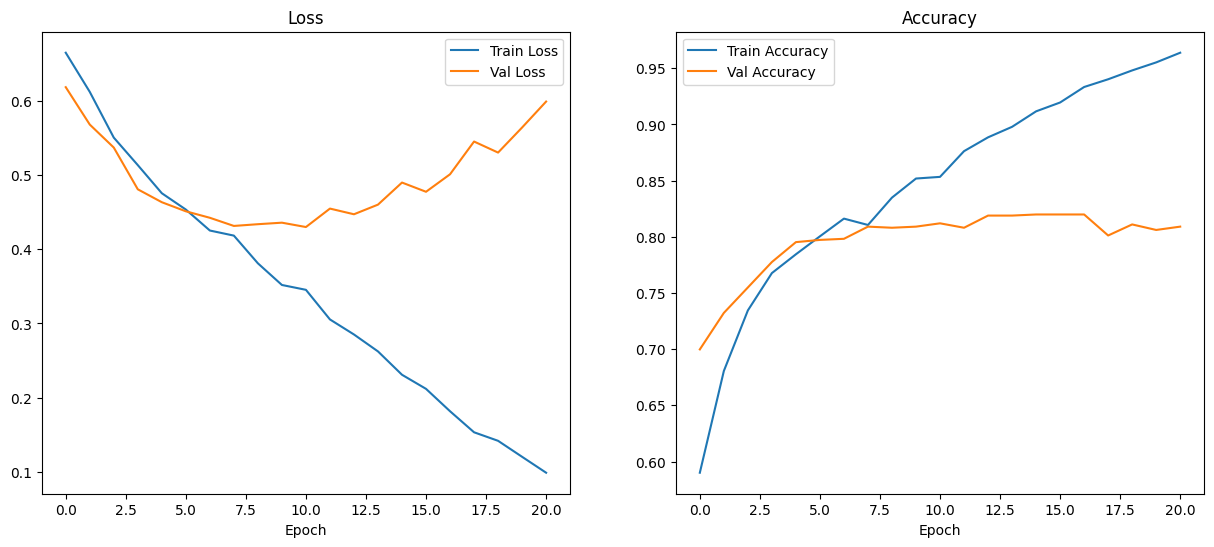

In [42]:
# print the plots
epoch_history(Bidirectional_GRU_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0     0.8217    0.8544    0.8377       577
           1     0.7981    0.7563    0.7766       439

    accuracy                         0.8120      1016
   macro avg     0.8099    0.8053    0.8072      1016
weighted avg     0.8115    0.8120    0.8113      1016



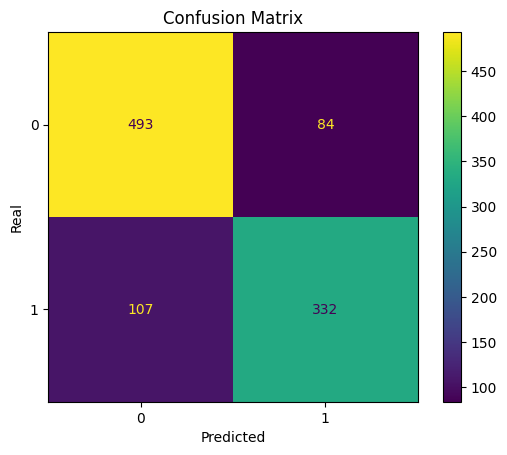

In [105]:
history_to_confusion_matrix(Bidirectional_GRU, X_val, y_val)


#Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

## Hyperparameter tuning

In [73]:
# set the grid for hyperparameter tuning
dropout_list = [0.1,0.4,0.7]
recurrent_dropout_list = [0.1,0.4,0.7]



In [69]:

model_result = []

for dropout in dropout_list:
  for recurrent_dropout in recurrent_dropout_list:

      model = Sequential()
      model.add(Embedding(input_dim=vocab_size,output_dim=dimention_of_vector,input_length=max_len,
                         weights=[init_weight],
                           trainable=True))



      model.add(Bidirectional(GRU(units=64,
                                        dropout=dropout,
                                        recurrent_dropout=recurrent_dropout)))
      # copy and paste from previous model
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(dropout))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      # use 1000 to accelarate the process
      model.fit(X_train, y_train, epochs=5, batch_size=1000, verbose=0)

      y_val_predicted = (model.predict(X_val) > 0.5).astype(int)

      f1_value = f1_score(y_val, y_val_predicted)
      accuracy_value = accuracy_score(y_val, y_val_predicted)



      model_result.append(((dropout, recurrent_dropout), f1_value,accuracy_value))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [71]:
best_combination = max(model_result, key=lambda x: x[2])

In [72]:
print("optimal F1" ,best_combination[1])
print("optimal Accuracy", best_combination[2])
print("dropout",best_combination[0][0], "recurrent_dropout",best_combination[0][1])


optimal F1 0.6394736842105263
optimal Accuracy 0.7303149606299213
dropout 0.1 recurrent_dropout 0.4


## Different Architectures

In [127]:
# create the Bidirectional_RNN model

Bidirectional_RNN = Sequential()

Bidirectional_RNN.add(Embedding(input_dim = vocab_size, output_dim = dimention_of_vector,input_length=max_len,
                    weights=[init_weight],
                    trainable=True))

Bidirectional_RNN.add(Bidirectional(GRU(64, dropout=0.4, recurrent_dropout=0.4)))

Bidirectional_RNN.add(Dense(64, activation='relu'))

Bidirectional_RNN.add(Dropout(0.4))

Bidirectional_RNN.add(Dense(1, activation='sigmoid'))

Bidirectional_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Bidirectional_RNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_52 (Embedding)        │ ?                      │     1,722,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_51                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,722,700 (6.57 MB)

 Trainable params: 1,722,700 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
RNN_history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=120,
                    batch_size=500,
                    callbacks=[early_stop])

Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8755 - loss: 0.3205 - val_accuracy: 0.8159 - val_loss: 0.4623
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8822 - loss: 0.2883 - val_accuracy: 0.8041 - val_loss: 0.4616
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8780 - loss: 0.3064 - val_accuracy: 0.8100 - val_loss: 0.4678
Epoch 4/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8845 - loss: 0.2964 - val_accuracy: 0.8091 - val_loss: 0.4688
Epoch 5/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8954 - loss: 0.2710 - val_accuracy: 0.8110 - val_loss: 0.4736
Epoch 6/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8994 - loss: 0.2605 - val_accuracy: 0.8071 - val_loss: 0.4784
Epoch 7/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9051 - loss: 0.2408 - val_accuracy: 0.8081 - val_loss: 0.4847
Epoch 8/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9098 - loss: 0.2431 - val_accuracy: 0.8051 - v

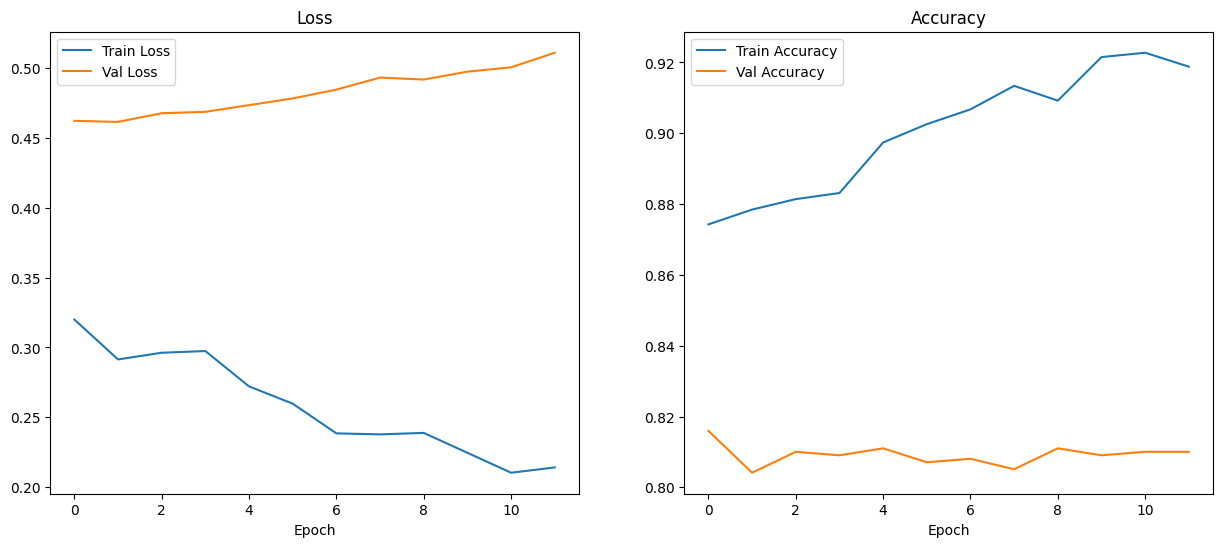

In [129]:
# print the plots
epoch_history(RNN_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
              precision    recall  f1-score   support

           0     0.7013    0.3865    0.4983       577
           1     0.4928    0.7836    0.6051       439

    accuracy                         0.5581      1016
   macro avg     0.5970    0.5850    0.5517      1016
weighted avg     0.6112    0.5581    0.5445      1016



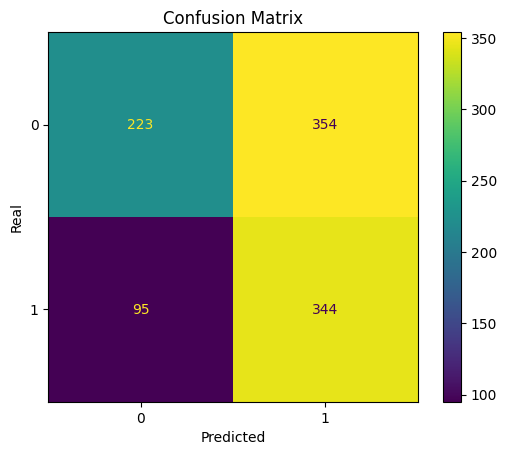

In [130]:
history_to_confusion_matrix(Bidirectional_RNN, X_val, y_val)

I ran a grid search and a Bidirectional_RNN model.

For the grid search for the hyperparameter tuning the result shows  that when
dropout=0.1, recurrent_dropout=0.4 (based on Accuracy value)

when the dropout is too hign the model will not be able to merge, but if the value is like above 0.7, the model will have low accuracy.

For the Bidirectional_RNN , it  has a very bad result ,the F1 score is so bad(around 0.5) and the training process is not stable , the loss_value will change very sharpely.



# Conclusion (15 pts)


## Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models?

Bidirectional_RNN model is much faster than Bidirectional_GRU model, but it is not stable,and the result is very bad

Bidirectional_GRU is much more stable than the Bidirectional_RNN, the accuracy of the validation data is not changing sharpely, and it took longger for the model to got the optimal result, while RNN merge very quick and the result is bad.

Also dropout , and recurrent_dropout are very important , if the value is too small, like 0.1 or 0.2,0.3 the model might overfiiting . When dropout 0.1 recurrent_dropout 0.4, i got the best result

The different nodes number in each layer does do actually make a huge different,
from 24 to 128 , the result are almost the same

## What improvements could you try in the future?

Try running grid search for more parameters on multiple GPUs.(I am doing the search in linear , this is very slow)

Try the Transformer model like BERT

Try using the Self-Attention method to enhance the ability of model to focus on imporatn information.

#Reference list for NLP

https://nlp.stanford.edu/projects/glove/